# AARRR 분석

In [1]:
import faulthandler 
from pyspark.sql import SparkSession 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct
import os
faulthandler.enable()   
spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()

In [2]:
def search(dirname):
    filenames = os.listdir(dirname)
    file_list = []
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        print(full_filename)
        file_list.append(full_filename)
    return file_list
data_path_list = search("D:/workspace/data/")

D:/workspace/data/2019-Dec.csv
D:/workspace/data/2019-Nov.csv
D:/workspace/data/2019-Oct.csv
D:/workspace/data/2020-Apr.csv
D:/workspace/data/2020-Feb.csv
D:/workspace/data/2020-Jan.csv
D:/workspace/data/2020-Mar.csv


In [3]:
for i, x in enumerate(data_path_list):
    file_path = x
    df = spark.read.csv(file_path, header=True)
    if i == 0:
        merged_df = df
    else:
        merged_df = merged_df.union(df)

In [4]:
merged_df.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-12-01 00:00:...|      view|   1005105|2232732093077520756|construction.tool...|  apple|1302.48|556695836|ca5eefc5-11f9-450...|
|2019-12-01 00:00:...|      view|  22700068|2232732091643068746|                NULL|  force| 102.96|577702456|de33debe-c7bf-44e...|
|2019-12-01 00:00:...|      view|   2402273|2232732100769874463|appliances.person...|  bosch| 313.52|539453785|5ee185a7-0689-4a3...|
|2019-12-01 00:00:...|  purchase|  26400248|2053013553056579841|computers.periphe...|   NULL| 132.31|535135317|61792a26-672f-4e6...|
|2019-12-01 00:00:...|      view|  20100164|2232732110089618156|    a

In [5]:
sorted_df = merged_df.orderBy('event_time')

In [6]:
sorted_df = merged_df.orderBy('event_time').show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|  33.20|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    NULL| 543.10|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [6]:
merged_df.createOrReplaceTempView("ecommerce")

# 1. Acquisition(고객 유치)
    - MAU, DAU

## DAU

In [8]:
dau = spark.sql("""
SELECT DATE(event_time) AS event_date, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_date
ORDER BY event_date
""")

In [9]:
dau.show()

+----------+------+
|event_date|   DAU|
+----------+------+
|2019-10-01|190188|
|2019-10-02|184965|
|2019-10-03|170668|
|2019-10-04|209410|
|2019-10-05|194958|
|2019-10-06|193210|
|2019-10-07|186951|
|2019-10-08|221204|
|2019-10-09|214140|
|2019-10-10|205321|
|2019-10-11|230533|
|2019-10-12|208355|
|2019-10-13|225942|
|2019-10-14|209089|
|2019-10-15|230135|
|2019-10-16|230199|
|2019-10-17|208477|
|2019-10-18|229463|
|2019-10-19|217920|
|2019-10-20|231849|
+----------+------+
only showing top 20 rows



In [9]:
import matplotlib as plt

df_dau = dau.toPandas()
plt.figure(figsize=(10,6))
plt.plot(df_dau['event_date'], df_dau['DAU'])
plt.show()

AttributeError: module 'matplotlib' has no attribute 'figure'

## MAU

In [12]:
mau = spark.sql("""
SELECT DATE_FORMAT(event_time, 'yyyy-mm') AS event_month, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_month
ORDER BY event_month
""")

In [11]:
mau.show()

SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.DATETIME_PATTERN_RECOGNITION] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to recognize '%Y-%m' pattern in the DateTimeFormatter. 1) You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0. 2) You can form a valid datetime pattern with the guide from 'https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html'.

In [15]:
mau = spark.sql("""
SELECT DATE_FORMAT(event_time, 'yyyy-MM') AS event_month, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
WHERE event_type = 'purchase'
GROUP BY event_month
ORDER BY event_month
""")

In [16]:
mau.show()

+-----------+------+
|event_month|   DAU|
+-----------+------+
|    2019-10|345250|
|    2019-11|440842|
|    2019-12|502203|
|    2020-01|357440|
|    2020-02|392986|
|    2020-03|453238|
|    2020-04|483209|
|    2020-05|  7510|
+-----------+------+



In [ ]:
mau = spark.sql("""
SELECT DATE_FORMAT(event_time, 'yyyy-MM') AS event_month, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_month
ORDER BY event_month
"""
                )

In [18]:
ch = spark.sql("""SELECT event_type
FROM ecommerce
WHERE category_id is NULL""")

In [19]:
ch.show()

+----------+
|event_type|
+----------+
+----------+



In [24]:
ch2 = spark.sql("""SELECT COUNT(*)
FROM ecommerce
WHERE event_type = 'remove_from_cart'""")

In [25]:
ch2.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



category_id 별 remove_from_cart 횟수
product_id 별 '' 횟수
category_id 별 remove_from_cart의 평균 금액
category_id 별 평균 금액


왜 카트에서 뺏을까??

category_id 별 remove_from_cart의 평균 금액
category_id 별 평균 금액 
비교해서 가격이 높으니깐 뺏을거다~~ 가정



In [26]:
ch3 = spark.sql("""SELECT AVG(price)
FROM ecommerce
WHERE event_type = 'remove_from_cart'
GROUP BY category_id""")

In [ ]:
spark.sql("SELECT event_type, count(*) AS count FROM ecommerce GROUP BY event_type").show()

In [32]:
ch3 = spark.sql("""SELECT COUNT(*)
FROM ecommerce
WHERE event_type = 'remove_from_cart'
""")

In [33]:
ch3.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [28]:
ch4 = spark.sql("""SELECT AVG(price)
FROM ecommerce
GROUP BY category_id""")

In [29]:
ch4.show()

+------------------+
|        avg(price)|
+------------------+
| 87.80797816758613|
| 450.9995915518444|
| 4.920704299196083|
|159.55224882901416|
|33.503011436308896|
| 11.66483814286157|
| 29.46086265396233|
| 41.40644277624123|
| 260.6987540917275|
| 52.77697654951005|
| 75.63604654380427|
| 76.09783351662296|
|28.097595909479214|
| 46.23472194346749|
| 309.6664289366987|
| 471.0196187308418|
| 34.68476078082908|
|40.398741436017374|
| 34.61137015546313|
|142.74526061125448|
+------------------+
only showing top 20 rows



In [30]:
ch5 = spark.sql("""SELECT AVG(price)
FROM ecommerce
WHERE event_type = 'purchase'
GROUP BY category_id""")

In [31]:
ch5.show()

+------------------+
|        avg(price)|
+------------------+
| 24.74642308922289|
|10.081231372549013|
|127.76749408424037|
|303.84773353751905|
| 41.72249476831091|
| 46.85953463203459|
|24.315160377358485|
| 318.5766890756304|
|248.54630952380944|
|15.519176470588231|
|112.58361111111097|
|18.588049308478638|
| 75.28369747899158|
| 47.70276503678062|
|62.890809678920434|
|  78.8290615316512|
| 72.98199999999999|
| 128.1508675799088|
| 145.4121944492329|
|   42.143284628872|
+------------------+
only showing top 20 rows



# 2. Activation(활성화)
    - DT(Duration Time, 체류시간)


## DT

In [ ]:
spark.sql('''SELECT user_session, 
                                MONTH(MAX(event_time)) AS DURATION_MONTH
                                DATE(MAX(event_time)) AS DURATION_DATE
                               MAX(event_time) - MIN(event_time) AS duration
                  FROM ecommerce 
                  GROUP BY user_session
                  '''
          )

In [32]:
duration = spark.sql('''SELECT user_session, 
                                MONTH(MAX(event_time)) AS DURATION_MONTH,
                                DATE(MAX(event_time)) AS DURATION_DATE,
                               MAX(event_time) - MIN(event_time) AS duration
                  FROM ecommerce 
                  GROUP BY user_session
                  '''
          )

In [33]:
duration.show()

+--------------------+--------------+-------------+--------+
|        user_session|DURATION_MONTH|DURATION_DATE|duration|
+--------------------+--------------+-------------+--------+
|000010c7-ce4b-4a2...|             3|   2020-03-07|    NULL|
|000020ec-d01e-4b6...|            12|   2019-12-16|    NULL|
|000023c0-9b3a-492...|             1|   2020-01-11|    NULL|
|00003a8a-eb72-494...|            12|   2019-12-21|    NULL|
|00003ede-f2e1-456...|             4|   2020-04-19|    NULL|
|00004742-1c19-4e8...|            11|   2019-11-29|    NULL|
|0000622b-746a-449...|             4|   2020-04-01|    NULL|
|00008098-f3a9-4ce...|            12|   2019-12-19|    NULL|
|000081ea-9376-4eb...|            10|   2019-10-24|    NULL|
|00008216-929c-4be...|             2|   2020-02-12|    NULL|
|00009293-d298-42b...|             4|   2020-04-30|    NULL|
|00009e35-76be-4f2...|             4|   2020-04-14|    NULL|
|0000bff5-7350-49a...|             4|   2020-04-30|    NULL|
|0000c722-6d8d-463...|  

지표 본다고 적어 놓은 애들 먼저 쓱 보고
전환율은 카윤트만 때리고
다른 것들을 보고 또 오자~~~

In [ ]:
duration.show()

In [ ]:
duration_month = spark.sql("""
WITH temp AS (
    SELECT user_session, 
    MONTH(MAX(event_time)) AS DURATION_MONTH
    DATE(MAX(event_time)) AS DURATION_DATE
    MAX(event_time) - MIN(event_time) AS duration
    FROM ecommerce 
    GROUP BY user_session
)
SELECT DURATION_DATE, AVG(duration) AS AVG_DURATION
FROM temp
GROUP BY DURATION_DATE
ORDERY BY DURATION_DATE
""")

In [ ]:
duration_month.show()

In [ ]:
"""
WITH temp AS (
    SELECT user_session, 
    MONTH(MAX(event_time)) AS DURATION_MONTH
    DATE(MAX(event_time)) AS DURATION_DATE
    MAX(event_time) - MIN(event_time) AS duration
    FROM ecommerce 
    GROUP BY user_session
)
SELECT DURATION_MONTH, AVG(duration) AS AVG_DURATION
FROM temp
GROUP BY DURATION_MONTH
ORDERY BY DURATION_MONTH
"""

# user_session 별로 view, purchase, cart의 수

In [22]:
pivot_session = spark.sql('''WITH source AS (
                                                SELECT user_session, event_type, COUNT(event_time) AS event_count
                                                FROM ecommerce
                                                GROUP BY user_session, event_type
                                                )
                            SELECT 
                                user_session,
                                SUM(CASE WHEN event_type = 'view' THEN event_count ELSE 0 END) AS view,
                                SUM(CASE WHEN event_type = 'cart' THEN event_count ELSE 0 END) AS cart,
                                SUM(CASE WHEN event_type = 'purchase' THEN event_count ELSE 0 END) AS purchase
                            FROM source
                            GROUP BY user_session
                            ORDER BY user_session
                        ''')

In [23]:
pivot_session.show()

+--------------------+----+----+--------+
|        user_session|view|cart|purchase|
+--------------------+----+----+--------+
|                NULL|  90| 132|       4|
|00000031-5225-42a...|   1|   0|       0|
|00000042-3e3f-42f...|   2|   0|       0|
|0000004b-b485-4bf...|   2|   0|       0|
|00000056-a206-40d...|   8|   0|       0|
|0000007c-adbf-4ed...|   1|   0|       0|
|00000083-8816-4d5...|  16|   1|       1|
|0000009d-1f5b-40b...|   1|   0|       0|
|00000108-fa90-4bf...|   1|   0|       0|
|0000013c-0ccc-4b8...|   1|   0|       0|
|00000162-3f83-4d1...|   2|   0|       0|
|000001d5-66f5-4fa...|   1|   0|       0|
|000001d5-f8f8-4e4...|   1|   0|       0|
|000001fd-1f89-45e...|   6|   4|       1|
|00000208-b6b8-44c...|   1|   0|       0|
|0000020c-8e6b-4d2...|   1|   0|       0|
|00000214-9e7b-4dd...|  16|   0|       0|
|0000022a-fe95-430...|   3|   0|       0|
|00000241-5dac-4d3...|   1|   0|       0|
|00000348-8463-483...|   1|   0|       0|
+--------------------+----+----+--

In [34]:
duration.createOrReplaceTempView('duration_table')

In [30]:

pivot_session.createOrReplaceTempView('session_pivot_table')

In [ ]:
iew_sesstion_avg_duration = spark.sql('''
                                                SELECT MEAN(d.duration)
                                                FROM duration_table AS d, 
                                                    (SELECT user_session, cart, purchase
                                                    FROM session_pivot_table
                                                    WHERE cart < 1 AND purchase < 1)   AS p
                                                WHERE d.user_session = p.user_session
                                        ''').show()


In [ ]:
purchase_sesstion_avg_duration = spark.sql('''
                                                SELECT MEAN(d.duration)
                                                FROM duration_table AS d, 
                                                    (SELECT user_session, purchase
                                                    FROM session_pivot_table
                                                    WHERE purchase > 0)   AS p
                                                WHERE d.user_session = p.user_session
                                        ''').show()

# funnel (event_type 별 count )

In [10]:
funnel = spark.sql("""
                   SELECT 
                        event_type, COUNT(*) AS CNT
                   FROM 
                        ecommerce
                   GROUP BY 
                        event_type
                   ORDER BY
                        CNT DESC
""")

In [13]:
funnel.show()

+----------+---------+
|event_type|      CNT|
+----------+---------+
|  purchase|  6848824|
|      cart| 19114063|
|      view|385746849|
+----------+---------+



In [8]:
df_funnel = funnel.toPandas()

twilight
twilight_shifted



In [25]:
df_funnel

,event_type,CNT
0,purchase,6848824
1,cart,19114063
2,view,385746849


In [9]:
import plotly.express as px
fig = px.funnel(data_frame= df_funnel, x = 'event_type', y = 'CNT')
fig.update_traces(texttemplate= '%{value:,.0f}') # 숫자 형식 지정
fig.show()

In [14]:
user_session_null = spark.sql("""
SELECT COUNT(*)
FROM ecommerce
WHERE user_session is NULL
""")

df.dropna(subset = ['user_session'])

In [15]:
user_session_null.show()

+--------+
|count(1)|
+--------+
|     226|
+--------+



In [19]:
user_session_null_permon = spark.sql("""
SELECT MONTH(event_time) AS MON, user_id, COUNT(*) AS CNT
FROM ecommerce
WHERE user_session is NULL
GROUP BY MON, user_id
HAVING CNT > 1
ORDER BY MON
""")

In [20]:
user_session_null_permon.show()

+---+---------+---+
|MON|  user_id|CNT|
+---+---------+---+
|  2|601555623|  2|
|  2|613107392|  2|
|  3|623037262|  2|
|  3|529199993|  2|
|  3|631671609|  2|
|  3|632848508|  4|
|  3|540233932|  6|
|  3|548157802|  2|
|  3|537196586|  3|
|  3|634567453| 10|
|  4|593733547|  3|
|  4|607289040|  3|
|  4|589370694|  2|
|  4|597371822|  2|
|  4|589231099|  2|
|  4|581532293|  2|
|  4|638581404|  4|
|  4|541757573|  2|
|  4|581415839|  3|
|  4|516304806|  2|
+---+---------+---+
only showing top 20 rows



In [17]:
user_session_null_eventtime = spark.sql("""
SELECT event_time, user_id, event_type, category_code
FROM ecommerce
WHERE user_session is NULL
""")

In [18]:
user_session_null_eventtime.show()

+--------------------+---------+----------+--------------------+
|          event_time|  user_id|event_type|       category_code|
+--------------------+---------+----------+--------------------+
|2019-12-02 08:15:...|580714819|      cart|appliances.kitche...|
|2019-12-03 10:08:...|519513506|      cart|auto.accessories....|
|2019-12-10 19:32:...|584193732|      cart|      apparel.shorts|
|2019-12-12 07:50:...|585526753|      cart|furniture.bedroom...|
|2019-12-12 16:19:...|585953165|      cart|furniture.kitchen...|
|2019-12-14 15:37:...|586879399|      cart|construction.tool...|
|2019-12-15 13:42:...|574084617|      cart|       sport.trainer|
|2019-12-18 14:35:...|587428481|      cart|appliances.kitche...|
|2019-12-19 06:23:...|589172852|      cart|electronics.audio...|
|2019-12-21 15:30:...|590035230|      cart|       sport.bicycle|
|2019-12-23 11:37:...|591290578|      cart|       sport.bicycle|
|2019-12-24 00:26:...|591580955|      cart|construction.tool...|
|2019-12-24 06:25:...|535

# RETENTION

## Monthly Retention

접속 했는지 여부 RETENTION


In [ ]:
retention_month = spark.sql("""
                            WITH cohort AS (
                                SELECT user_id, MIN(event_time) AS cohort_time
                                FROM ecommerce
                                GROUP BY user_id
                            ), 
                            


""")

In [36]:
view_data = spark.sql(""" SELECT COUNT(*) FROM (
                          SELECT user_id, MIN(event_time)
                          FROM ecommerce
                          GROUP BY user_id, event_time)
                          """)

view_data.show()

+---------+
| count(1)|
+---------+
|408973445|
+---------+



In [37]:
view_data = spark.sql(""" SELECT COUNT(*) FROM (
                          SELECT user_id, MIN(event_time)
                          FROM ecommerce
                          WHERE event_type = "view"
                          GROUP BY user_id, event_time)
                          """)

view_data.show()

+---------+
| count(1)|
+---------+
|384715674|
+---------+



In [38]:
retention_range_30 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time))
                                ORDER BY diff_month

                          """)


In [39]:
retention_range_30.show()

+----------+--------+
|diff_month|user_cnt|
+----------+--------+
|         0|15639803|
|         1| 3462320|
|         2| 2641431|
|         3| 1981956|
|         4| 1467672|
|         5| 1012141|
|         6|  546531|
|         7|    2378|
+----------+--------+



In [44]:
retention_range_30 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT MONTH(first_interaction_time) AS MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time))
                                ORDER BY diff_month

                          """)


In [45]:
retention_range_30.show()

+-----+----------+--------+
|MONTH|diff_month|user_cnt|
+-----+----------+--------+
|   11|         0| 2294359|
|    1|         0| 2145747|
|    4|         0| 2109972|
|   12|         0| 2539989|
|   10|         0| 3022290|
|    3|         0| 1689867|
|    2|         0| 1837579|
|   12|         1|  546173|
|    3|         1|  219013|
|   10|         1| 1280588|
|    4|         1|     235|
|    1|         1|  414020|
|    2|         1|  281991|
|   11|         1|  720300|
|   12|         2|  451361|
|   11|         2|  569300|
|    2|         2|  188601|
|    3|         2|     173|
|   10|         2| 1146833|
|    1|         2|  285163|
+-----+----------+--------+
only showing top 20 rows



In [46]:
df_retention_30 = retention_range_30.toPandas()

In [49]:
df_retention_30.sort_values(by=['MONTH','diff_month'])

,MONTH,diff_month,user_cnt
1,1,0,2145747
11,1,1,414020
19,1,2,285163
22,1,3,188597
26,1,4,152
6,2,0,1837579
12,2,1,281991
16,2,2,188601
24,2,3,231
5,3,0,1689867


In [94]:
df_retention_30_pivot = df_retention_30.pivot(index='MONTH',columns='diff_month',values='user_cnt').reindex([10,11,12,1,2,3,4])

In [87]:
df_retention_30_pivot

diff_month,0,1,2,3,4,5,6,7
MONTH,,,,,,,,
10,3022290.0,1280588.0,1146833.0,957235.0,857089.0,724136.0,546200.0,2378.0
11,2294359.0,720300.0,569300.0,499862.0,398422.0,287794.0,331.0,NaN
12,2539989.0,546173.0,451361.0,336031.0,212009.0,211.0,NaN,NaN
1,2145747.0,414020.0,285163.0,188597.0,152.0,NaN,NaN,NaN
2,1837579.0,281991.0,188601.0,231.0,NaN,NaN,NaN,NaN
3,1689867.0,219013.0,173.0,NaN,NaN,NaN,NaN,NaN
4,2109972.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
import numpy as np
if df_retention_30_pivot.isnull().iloc[5,5]:
    print('a')

a


In [95]:
for i in range(len(df_retention_30_pivot)):
    a = df_retention_30_pivot.iloc[i,0]
    for j in range(len(df_retention_30_pivot.columns)):
        if df_retention_30_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_30_pivot.iloc[i,j] = round(df_retention_30_pivot.iloc[i,j] / a, 4)


In [96]:
df_retention_30_pivot

diff_month,0,1,2,3,4,5,6,7
MONTH,,,,,,,,
10,1.0,0.4237,0.3795,0.3167,0.2836,0.2396,0.1807,0.0008
11,1.0,0.3139,0.2481,0.2179,0.1737,0.1254,0.0001,NaN
12,1.0,0.2150,0.1777,0.1323,0.0835,0.0001,NaN,NaN
1,1.0,0.1929,0.1329,0.0879,0.0001,NaN,NaN,NaN
2,1.0,0.1535,0.1026,0.0001,NaN,NaN,NaN,NaN
3,1.0,0.1296,0.0001,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0001,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='diff_month', ylabel='MONTH'>

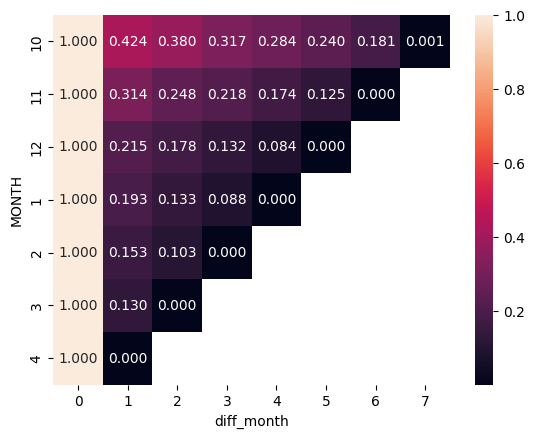

In [98]:
import seaborn as sns
sns.heatmap(df_retention_30_pivot, annot=True, fmt=".3f")

In [42]:
retention_range_7 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT DATEDIFF(event_time, first_interaction_time) AS diff_days,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY DATEDIFF(event_time, first_interaction_time)
                                HAVING DATEDIFF(event_time, first_interaction_time) <= 7
                                ORDER BY diff_days
                          """)



In [43]:
retention_range_7.show()

+---------+--------+
|diff_days|user_cnt|
+---------+--------+
|        0|15639803|
|        1| 1408684|
|        2|  938826|
|        3|  784316|
|        4|  701485|
|        5|  645066|
|        6|  615962|
|        7|  593861|
+---------+--------+



In [40]:
spark.sql("SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 1)) FROM ecommerce").show()

+------------------------------------+
|substring_index(category_code, ., 1)|
+------------------------------------+
|                            medicine|
|                           computers|
|                                auto|
|                          stationery|
|                               sport|
|                             apparel|
|                          appliances|
|                        country_yard|
|                           furniture|
|                         accessories|
|                                kids|
|                         electronics|
|                        construction|
|                                NULL|
+------------------------------------+



카테고리 갯수 : null 제외 13개

In [ ]:
# spark.sql("FROM (SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 1)) FROM ecommerce)").show()

In [ ]:
# 7일 기준 (날짜 포함)
retention_range_7 = spark.sql("""
                                WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM sample
                                    GROUP BY user_id
                                )
                                
                                SELECT DATE(first_interaction_time) AS start_date,
                                COUNT(DISTINCT s.user_id) as user_cnt,
                                COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 0 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id) AS day_0_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 1 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_1_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 2 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_2_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 3 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_3_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 4 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_4_ratio ,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 5 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_5_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 6 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_6_ratio,
                                ROUND(COUNT(DISTINCT CASE WHEN 
                                                    DATEDIFF(event_time, first_interaction_time) = 7 THEN s.user_id 
                                                    END) / COUNT(DISTINCT s.user_id),4) AS day_7_ratio                                                          
                                                    
                                                    
                                FROM sample s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY DATE(first_interaction_time)
                                ORDER BY start_date                 
                            """)